# STATS 370 Final project

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [2]:
%load_ext autoreload
%autoreload 2

from plot_utils import plot_dist, plot_marginals, plot_acorr, set_plt_settings
from dist_utils import prob_post, value_mh_cand, prob_mh_cand
from dist_utils import val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam
from dist_utils import prob_HMC
from mc_utils import MH, leapfrog, HMC

set_plt_settings()

In [3]:
# constants
THETA_LABELS = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']

In [4]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = torch.tensor(data[:,0].astype(int))
Y = torch.tensor(data[:, 1:], requires_grad=True)

# Metropolis Hasting
### Grid search for best hyperparameters

In [5]:
# grid search
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
burn_in = 100
T = 500 + burn_in
lag_steps = [10, 50]
acorr_threshold = 0.2
accept_threshold = 0.3

report_mh = {}
best_accept_mh = 0.0
best_acorr_mh = T

vmgs = [0.01, 0.05, 0.1]
vts = [0.01, 0.05, 0.1]
vsss = [0.005, 0.001, 0.05]
best_params_mh = (vmgs[0], vts[0], vsss[0])

In [6]:
# search hyperparameter space
for vmg in tqdm(vmgs):
    for vt in vts:
        for vss in vsss:
            # run MH
            xt, cands, status = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T, verbose=False)
            # get and log stats
            pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
            lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=xt, nlags=T/2)
            max_steps = 0
            for i in range(lags.shape[1]):
                max_steps = np.maximum(max_steps, np.min(np.where(lags[:,i] < acorr_threshold)))
            report_mh[vss, vt, vmg] = [pct_accept, max_steps]
            
            # remember best (defined as better accuracy while preserving lag)
            if (pct_accept > accept_threshold) & (max_steps < best_acorr_mh):
                best_accept_mh = pct_accept
                best_params_mh = (vmg, vt, vss)

print('best parameters (var mu/gam, var tau, var ss):', best_params_mh)

100%|█████████████████████████████████████████████| 3/3 [00:31<00:00, 10.55s/it]

best parameters (var mu/gam, var tau, var ss): (0.01, 0.01, 0.005)


In [13]:
report_mh_pd = pd.DataFrame(report_mh).T
report_mh_pd = report_mh_pd.reset_index()
report_mh_pd.columns = ['nu_ss', 'nu_tau', 'nu_mg', 'Acceptance rate', f'Max lag > {acorr_threshold}']
report_mh_pd.nu_ss = report_mh_pd.nu_ss.round(5)
report_mh_pd.nu_tau = report_mh_pd.nu_tau.round(2)
report_mh_pd.nu_mg = report_mh_pd.nu_mg.round(2)

print(report_mh_pd.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 nu\_ss &  nu\_tau &  nu\_mg &  Acceptance rate &  Max lag > 0.2 \\
\midrule
 0.005 &    0.01 &   0.01 &         0.311667 &           94.0 \\
 0.001 &    0.01 &   0.01 &         0.373333 &           84.0 \\
 0.050 &    0.01 &   0.01 &         0.253333 &           36.0 \\
 0.005 &    0.05 &   0.01 &         0.206667 &           79.0 \\
 0.001 &    0.05 &   0.01 &         0.248333 &           63.0 \\
 0.050 &    0.05 &   0.01 &         0.198333 &           44.0 \\
 0.005 &    0.10 &   0.01 &         0.193333 &          153.0 \\
 0.001 &    0.10 &   0.01 &         0.233333 &           85.0 \\
 0.050 &    0.10 &   0.01 &         0.171667 &           32.0 \\
 0.005 &    0.01 &   0.05 &         0.091667 &           65.0 \\
 0.001 &    0.01 &   0.05 &         0.165000 &          142.0 \\
 0.050 &    0.01 &   0.05 &         0.110000 &           32.0 \\
 0.005 &    0.05 &   0.05 &         0.088333 &          157.0 \\
 0.001 &    0.05 &   0.05 &         0.128333 &

/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_98511/3198012458.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report_mh_pd.to_latex(index=False))


### Run with selected hyperparameters for the proposal distribution

In [14]:
# optimal parameters
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 100000
vmg, vt, vss = best_params_mh

In [5]:
# toy parameters
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
vmg, vt, vss = (0.01, 0.01, 0.01)
T = 10000

In [15]:
xt_mh, cands_mh, status_mh = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T)

100%|██████████████████████████████████| 100000/100000 [03:35<00:00, 463.72it/s]


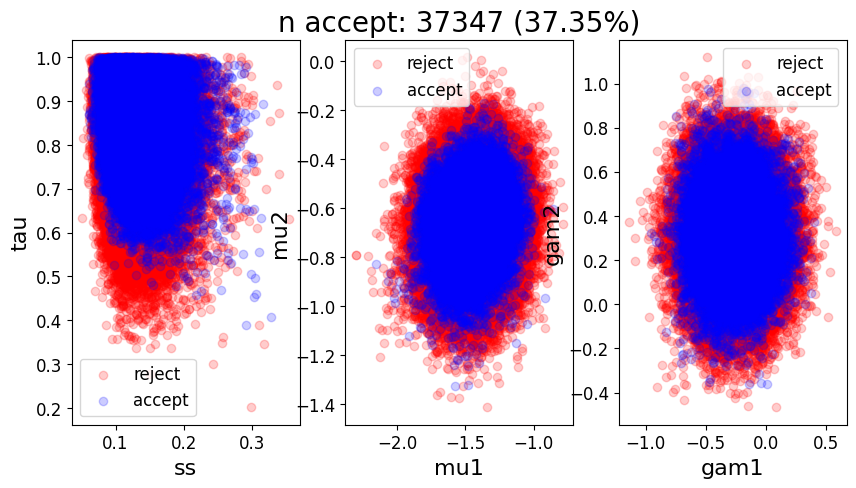

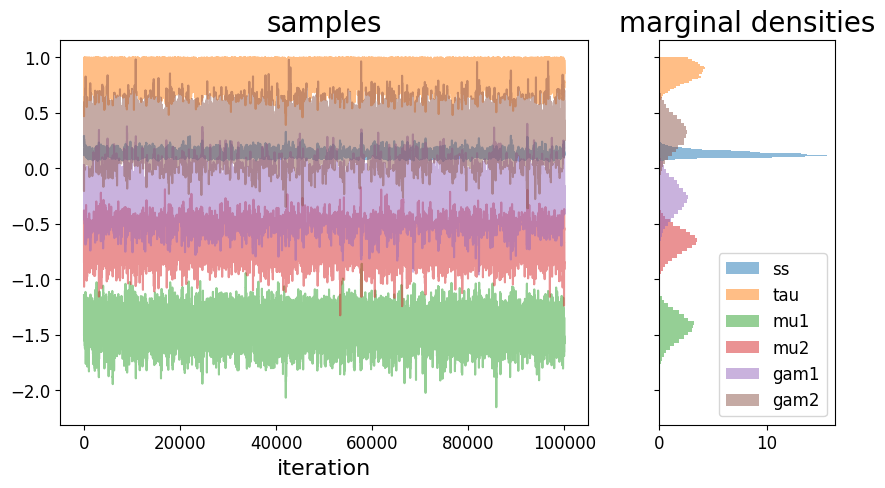

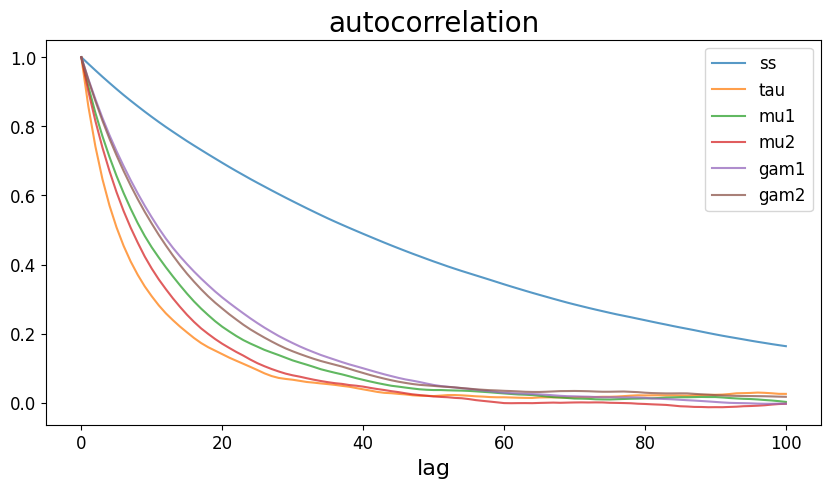

In [16]:
plot_dist(cands_mh, plot_status=True, status=status_mh, fname='mh_dist')
plot_marginals(xt_mh, fname='mh_marg')
plot_acorr(xt_mh, nlags=100, fname='mh_acorr')

In [21]:
# read-out statistics
stats_mh = {}
stats_mh['mean'] = np.mean(xt_mh, axis=0)
stats_mh['var'] = np.var(xt_mh, axis=0)
stats_mh['median'] = np.median(xt_mh, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_mh[f'p{pctl}'] = np.percentile(xt_mh, pctl, axis=0)
stats_mh = pd.DataFrame(stats_mh).T
stats_mh.columns = THETA_LABELS
print('univariate statistics')
print(stats_mh.to_latex())

univariate statistics
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
mean   &  0.128855 &  0.856592 & -1.437832 & -0.660407 & -0.269792 &  0.316120 \\
var    &  0.000854 &  0.007508 &  0.016422 &  0.013851 &  0.024934 &  0.023575 \\
median &  0.124435 &  0.864481 & -1.432695 & -0.657491 & -0.270956 &  0.317396 \\
p0     &  0.060584 &  0.389299 & -2.154638 & -1.326388 & -0.958255 & -0.361611 \\
p10    &  0.095844 &  0.738386 & -1.602141 & -0.809834 & -0.470537 &  0.121178 \\
p25    &  0.107768 &  0.798937 & -1.520030 & -0.735483 & -0.373689 &  0.214412 \\
p50    &  0.124435 &  0.864481 & -1.432695 & -0.657491 & -0.270956 &  0.317396 \\
p75    &  0.145736 &  0.924773 & -1.350404 & -0.580824 & -0.166230 &  0.418696 \\
p90    &  0.167346 &  0.966222 & -1.279685 & -0.514553 & -0.070925 &  0.509682 \\
p100   &  0.327578 &  0.999997 & -0.861472 & -0.172091 &  0.399618 &  0.980294 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_98511/1123338245.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_mh.to_latex())


In [22]:
# covariance
cov_mh = pd.DataFrame(np.cov(xt_mh.T))
cov_mh.columns = THETA_LABELS
cov_mh.index = THETA_LABELS
print('covariance')
print(cov_mh.to_latex())

covariance
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
ss   &  0.000854 & -0.000323 & -0.000197 & -0.000117 &  0.000087 & -0.000238 \\
tau  & -0.000323 &  0.007508 &  0.005160 &  0.003291 & -0.000687 &  0.000761 \\
mu1  & -0.000197 &  0.005160 &  0.016422 &  0.002575 & -0.007119 &  0.000374 \\
mu2  & -0.000117 &  0.003291 &  0.002575 &  0.013851 & -0.000793 & -0.005262 \\
gam1 &  0.000087 & -0.000687 & -0.007119 & -0.000793 &  0.024934 & -0.000133 \\
gam2 & -0.000238 &  0.000761 &  0.000374 & -0.005262 & -0.000133 &  0.023575 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_98511/2971513399.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cov_mh.to_latex())


# Gibs sampling

In [19]:
T = 100000
xt_g = []
continuous_scan = True
cond_dists = [val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam]

# Initialize then iterate
x0 = np.array((0.1, 0.75, np.array([0,0]), np.array([0,0])), dtype=object)
x = x0

for t in tqdm(range(T)):
    # sample iteratively from conditional distributions
    # determine scan
    if continuous_scan:
        update_idx = np.array(range(4))
    else:
        update_idx = np.random.choice(range(4), 4, replace=False)
    
    for j in update_idx:
        x[j] = cond_dists[j](x, Y.detach().numpy(), groups)
    
    # record in flattened state
    xt_g += [np.hstack(x)]

xt_g = np.array(xt_g)

100%|██████████████████████████████████| 100000/100000 [01:44<00:00, 959.25it/s]


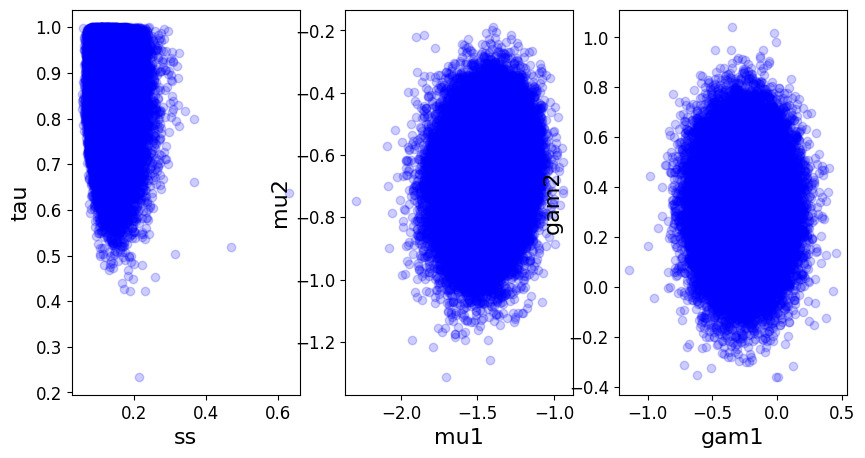

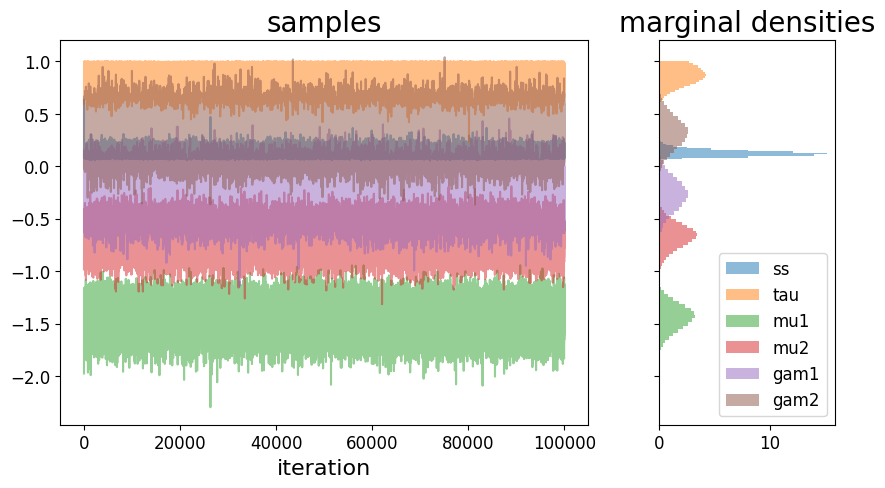

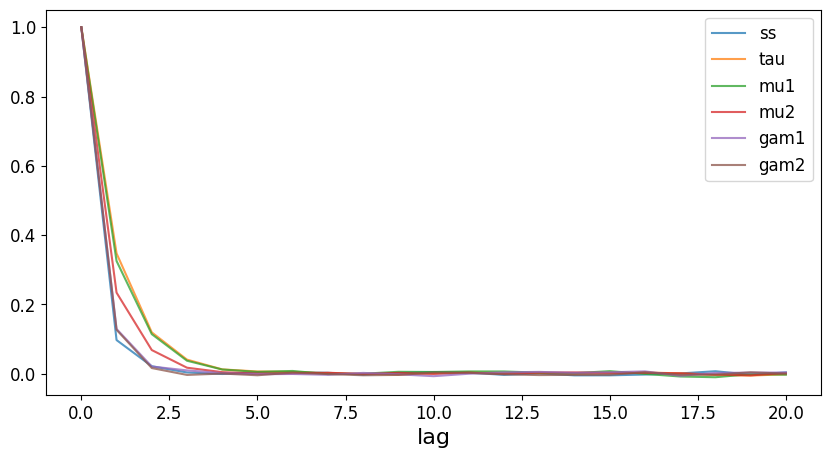

In [20]:
plot_dist(xt_g, plot_status=False, fname='gibbs_dist')
plot_marginals(xt_g, fname='gibbs_marg')
plot_acorr(xt_g, nlags=20, fname='gibbs_acorr')

In [24]:
# read-out statistics
stats_g = {}
stats_g['mean'] = np.mean(xt_g, axis=0)
stats_g['var'] = np.var(xt_g, axis=0)
stats_g['median'] = np.median(xt_g, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_g[f'p{pctl}'] = np.percentile(xt_g, pctl, axis=0)
stats_g = pd.DataFrame(stats_g).T
stats_g.columns = THETA_LABELS
print('univariate statistics')
print(stats_mh.to_latex())

univariate statistics
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
mean   &  0.128855 &  0.856592 & -1.437832 & -0.660407 & -0.269792 &  0.316120 \\
var    &  0.000854 &  0.007508 &  0.016422 &  0.013851 &  0.024934 &  0.023575 \\
median &  0.124435 &  0.864481 & -1.432695 & -0.657491 & -0.270956 &  0.317396 \\
p0     &  0.060584 &  0.389299 & -2.154638 & -1.326388 & -0.958255 & -0.361611 \\
p10    &  0.095844 &  0.738386 & -1.602141 & -0.809834 & -0.470537 &  0.121178 \\
p25    &  0.107768 &  0.798937 & -1.520030 & -0.735483 & -0.373689 &  0.214412 \\
p50    &  0.124435 &  0.864481 & -1.432695 & -0.657491 & -0.270956 &  0.317396 \\
p75    &  0.145736 &  0.924773 & -1.350404 & -0.580824 & -0.166230 &  0.418696 \\
p90    &  0.167346 &  0.966222 & -1.279685 & -0.514553 & -0.070925 &  0.509682 \\
p100   &  0.327578 &  0.999997 & -0.861472 & -0.172091 &  0.399618 &  0.980294 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_98511/1753597990.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_mh.to_latex())


In [25]:
# covariance
cov_g = pd.DataFrame(np.cov(xt_g.T))
cov_g.columns = THETA_LABELS
cov_g.index = THETA_LABELS
print('covariance')
print(cov_g.to_latex())

covariance
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
ss   &  0.000829 & -0.000252 & -0.000165 & -0.000096 & -0.000002 & -0.000044 \\
tau  & -0.000252 &  0.007479 &  0.005188 &  0.003529 & -0.000656 &  0.000722 \\
mu1  & -0.000165 &  0.005188 &  0.016047 &  0.002465 & -0.006474 &  0.000578 \\
mu2  & -0.000096 &  0.003529 &  0.002465 &  0.014061 & -0.000331 & -0.005675 \\
gam1 & -0.000002 & -0.000656 & -0.006474 & -0.000331 &  0.023364 & -0.000024 \\
gam2 & -0.000044 &  0.000722 &  0.000578 & -0.005675 & -0.000024 &  0.023471 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_98511/2606517917.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cov_g.to_latex())


# Hamiltonian Monte Carlo

### Grid search

In [41]:
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
scale = 1000 # used to implement boundary constraint on sigma and tau
T = 300 # iterations for grid search
burn_in = 0
acorr_threshold = 0.5
steps_threshold = 75
report_hmc = {}
best_accept_hmc = 0.0

# hyperparameter grid
M_rats = [
#     [1, 1, 1, 1, 1, 1],
#       [0.5, 1, 1, 1, 1, 1],
      [0.25, 0.5, 1, 1, 1, 1],
#       [0.25, 0.5, 1, 1, 0.75, 0.75]
]
M_scales = [1, 1.5, 2]
Ls = [5, 10, 20]
epss = [0.01, 0.001, 0.0001]
best_params_hmc = (M_rats[0], M_scales[0], Ls[0], epss[0])

# search hyperparameter space
for i, M_rat in enumerate(tqdm(M_rats, disable=True)):
    for M_scale in M_scales:
        M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
        M_inv = torch.linalg.inv(M)
        p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
        for L in Ls:
            for eps in epss:
                print('running:', M_rat, M_scale, L, eps)
                # run MH
                qt, cands, status = HMC(q=q0, p=p0, Y=Y, groups=groups, M=M, M_inv=M_inv, 
                                        eps=eps, L=L, T=T, verbose=False)
                # get and log stats
                pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
                lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=qt, nlags=T/10)
                steps = np.argmin(np.abs(lags - acorr_threshold), axis=0).tolist()
                report_hmc[i, M_scale, L, eps] = [pct_accept] + steps
                
                # remember best
                if (pct_accept > best_accept_hmc):
                    best_accept_hmc = pct_accept
                    best_params_hmc = (M_rat, M_scale, L, eps)

print('best parameters (Mrat, Mscale, L, eps):', best_params_hmc)

running: [0.25, 0.5, 1, 1, 1, 1] 1 5 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1 5 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1 5 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1 10 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1 10 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1 10 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1 20 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1 20 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1 20 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 5 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 5 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 5 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 10 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 10 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 10 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 20 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 20 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 1.5 20 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 2 5 0.01
running: [0.25, 0.5, 1, 1, 1, 1] 2 5 0.001
running: [0.25, 0.5, 1, 1, 1, 1] 2 5 0.0001
running: [0.25, 0.5, 1, 1, 1, 1] 2 10 0.01
running: [0.25, 0.5, 1, 

### Run with best hyperparams

In [42]:
# best parameters
T=10000
M_rat, M_scale, L, eps = best_params_hmc
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

In [50]:
# toy parameters
T=10000
M_rat, M_scale, L, eps = ([0.25, 0.5, 1, 1, 1, 1], 1.5, 30, 0.005)
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

In [51]:
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0], dtype=torch.float)
p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
q_hmc, cands_hmc, status_hmc = HMC(q0, p0, Y, groups, M, M_inv, eps, L, T)

100%|█████████████████████████████████████| 10000/10000 [07:41<00:00, 21.68it/s]


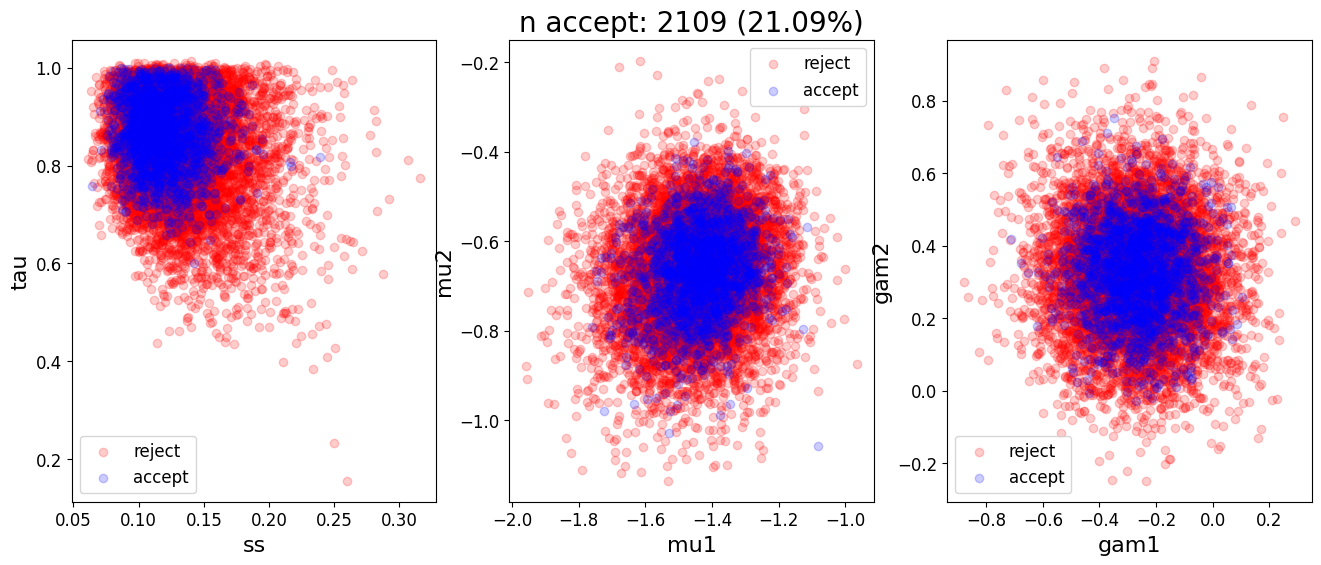

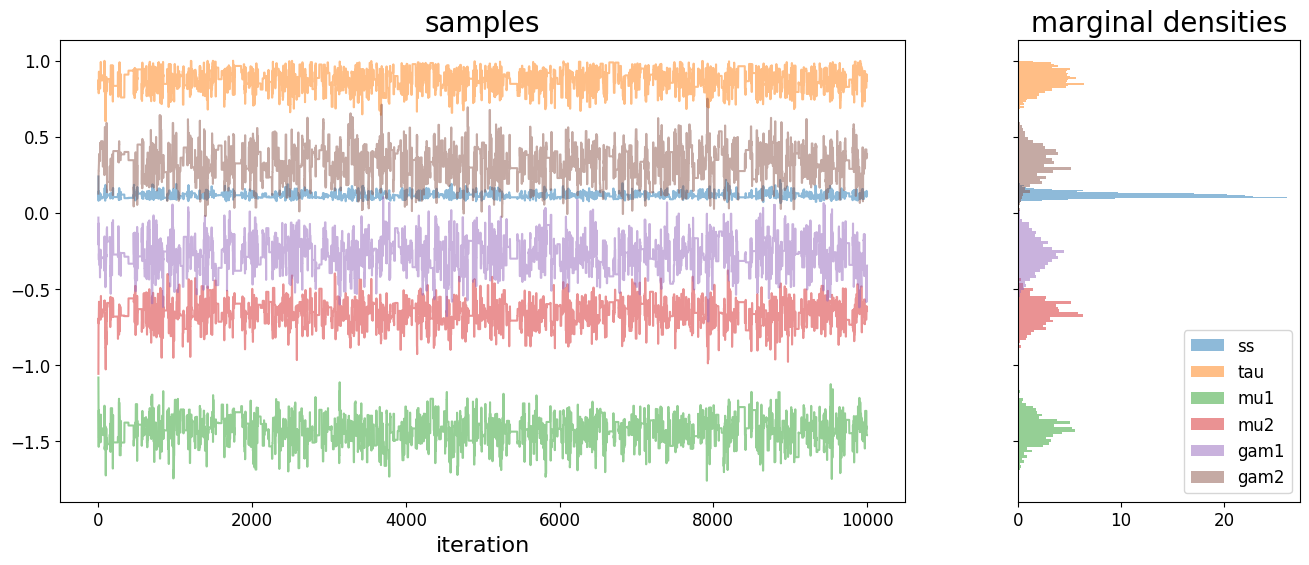

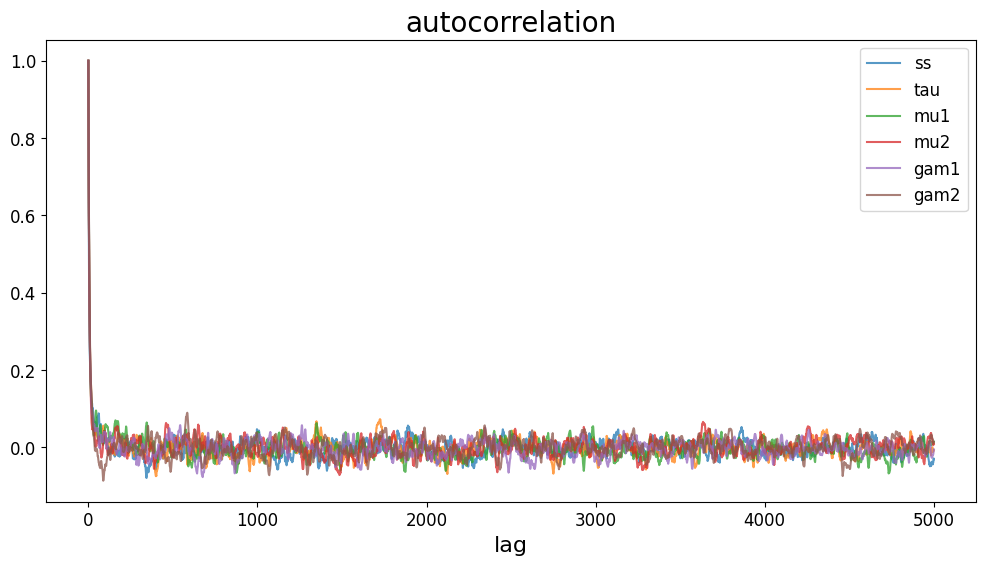

In [52]:
plot_dist(cands_hmc, plot_status=True, status=status_hmc)
plot_marginals(q_hmc)
plot_acorr(q_hmc)

In [53]:
# read-out statistics
stats_hmc = {}
stats_hmc['mean'] = np.mean(q_hmc, axis=0)
stats_hmc['var'] = np.var(q_hmc, axis=0)
stats_hmc['median'] = np.median(q_hmc, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:s
    stats_hmc[f'p{pctl}'] = np.percentile(q_hmc, pctl, axis=0)
stats_hmc = pd.DataFrame(stats_hmc).T
stats_hmc.columns = THETA_LABELS
print('univariate statistics')
display(stats_hmc)

# covariance
cov_hmc = pd.DataFrame(np.cov(q_hmc.T))
cov_hmc.columns = THETA_LABELS
cov_hmc.index = THETA_LABELS
print('covariance')
display(cov_hmc)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.116504,0.876061,-1.426506,-0.655593,-0.271189,0.328081
var,0.000348,0.004600,0.008185,0.007247,0.012136,0.011659
median,0.114722,0.879601,-1.423761,-0.656468,-0.269686,0.327901
p0,0.064362,0.601320,-1.760187,-1.057748,-0.713246,-0.026835
p10,0.096061,0.782554,-1.537226,-0.762930,-0.415536,0.191056
p25,0.102551,0.830283,-1.486731,-0.708031,-0.342834,0.258800
p50,0.114722,0.879601,-1.423761,-0.656468,-0.269686,0.327901
p75,0.127469,0.929382,-1.369389,-0.596565,-0.196123,0.404570
p90,0.142349,0.965406,-1.310156,-0.552663,-0.125584,0.457856
p100,0.239091,0.999837,-1.081980,-0.378013,0.103744,0.750497


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.000348,-0.000107,-0.000072,-0.000149,0.000059,-0.000006
tau,-0.000107,0.004601,0.003278,0.002411,-0.000979,0.000122
mu1,-0.000072,0.003278,0.008185,0.001597,-0.003621,0.000201
mu2,-0.000149,0.002411,0.001597,0.007248,-0.000028,-0.003019
gam1,0.000059,-0.000979,-0.003621,-0.000028,0.012137,-0.000362
gam2,-0.000006,0.000122,0.000201,-0.003019,-0.000362,0.011660


# Importance sampling

In [4]:
def is_tdist_params(Y, groups):
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    # t distribution parameters for mu and gamma
    M = (torch.sum(torch.square(Y[groups==1] - torch.mean(Y[groups == 1], axis=0))) + 
         torch.sum(torch.square(Y[groups==2] - torch.mean(Y[groups == 2], axis=0)))).detach().numpy()
    t_nu = 2*(ns[0] + ns[1]) - 4
    t_Sigma = M/t_nu * torch.diag(torch.tensor([1/ns[0], 1/ns[0], 1/ns[1], 1/ns[1]]))
    t_mu = torch.cat([torch.mean(Y[groups == 1], axis=0), torch.mean(Y[groups == 2], axis=0)]).detach().numpy()
    
    return t_mu, t_Sigma, t_nu

In [5]:
def val_is_cand(Y, groups):
    std_d = 0.001
    
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
   
    # sample mu and gamma from t
    t_mu, t_Sigma, t_nu = is_tdist_params(Y, groups)

    mu1, mu2, gam1, gam2 = sps.multivariate_t.rvs(loc=t_mu, shape=t_Sigma, df=t_nu)
    mu = torch.tensor([mu1, mu2])
    gam = torch.tensor([gam1, gam2])
    
    # sample ss from inverse gamma
    sum_square = (torch.sum(torch.square(Y[groups == 1] - mu)) + 
                  torch.sum(torch.square(Y[groups == 2] - gam))).detach().numpy()
    ss = sps.invgamma.rvs(a=ns[0] + ns[1], scale=sum_square/2)
    
    tau = sps.uniform.rvs(0, 1)
    
    return ss, tau, mu1, mu2, gam1, gam2
    

In [6]:
def weight_is_cand(theta, Y, groups):
    # unravel theta
    ss, tau, mu1, mu2, gam1, gam2 = theta
    mu = torch.tensor([mu1, mu2])
    gam = torch.tensor([gam1, gam2])
    
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    sum_square = (torch.sum(torch.square(Y[groups == 3] - (mu + gam)/2)) + 
                  torch.sum(torch.square(Y[groups == 4] - tau*mu - (1-tau)*gam)))
    
    u = (1/ss)**(ns[2] + ns[3]) * torch.exp(-1/(2*ss) * sum_square)
    
    return u

In [7]:
def weight_is_cand2(theta, Y, groups):
    # unravel theta
    ss, tau, mu1, mu2, gam1, gam2 = theta
    mu = torch.tensor([mu1, mu2])
    gam = torch.tensor([gam1, gam2])
    mu_gam = np.hstack([mu.detach().numpy(), gam.detach().numpy()])
    
    t_mu, t_Sigma, t_nu = is_tdist_params(Y, groups)
    prob_mugam = sps.multivariate_t.pdf(x=mu_gam, loc=t_mu, shape=t_Sigma, df=t_nu)
    
    sum_square = (torch.sum(torch.square(Y[groups == 1] - mu)) + 
                  torch.sum(torch.square(Y[groups == 2] - gam))).detach().numpy()
    prob_ss = sps.invgamma.pdf(x=ss, a=ns[0] + ns[1], scale=sum_square/2)
    
    u = prob_post(theta, Y, groups) / (prob_mugam * prob_ss)
    
    return u

In [9]:
T = 1000000
theta = torch.tensor([val_is_cand(Y, groups) for i in tqdm(range(T))])
u = torch.tensor([weight_is_cand(theta=theta[i,:], Y=Y, groups=groups) for i in range(theta.shape[0])])
w = u / torch.sum(u)
theta_hat = theta * np.reshape(w, (w.shape[0],1))

100%|███████████████████████████████| 1000000/1000000 [08:40<00:00, 1920.33it/s]


In [10]:
# mean
torch.sum(theta_hat, axis=0)

tensor([ 0.1274,  0.8564, -1.4359, -0.6609, -0.2697,  0.3193],
       dtype=torch.float64)

In [11]:
# variance
torch.sum(torch.square(theta - torch.mean(theta, axis=0)) * torch.reshape(w, (w.shape[0],1)), axis=0)

tensor([0.0045, 0.1345, 0.0167, 0.0706, 0.0293, 0.0462], dtype=torch.float64)

In [12]:
# histogram
n = 100
bins = torch.stack([
    torch.linspace(0, 0.5, n),
    torch.linspace(0, 1, n),
    torch.linspace(-2, 0, n),
    torch.linspace(-2, 0, n),
    torch.linspace(-1, 1, n),
    torch.linspace(-1, 1, n)]).T
i = 10
j = 2

vals = np.zeros([n, theta.shape[1]])
for j in range(theta.shape[1]):
    for i in range(n-1):
        vals[i,j] += [torch.sum(((theta[:,j] >= bins[i,j]) & (theta[:,j] < bins[i+1,j])*1).float() * w).detach().numpy()]


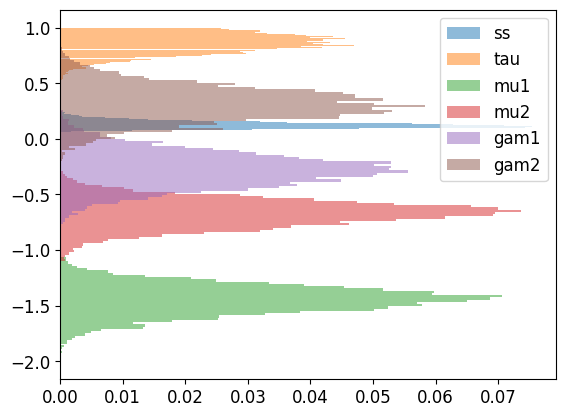

In [13]:
for j in range(bins.shape[1]):
    plt.barh(y=bins[:,j], width=vals[:,j], height=(bins[:,j].max() - bins[:,j].min())/n, alpha=0.5, label=THETA_LABELS[j])
    
plt.legend()
plt.show()

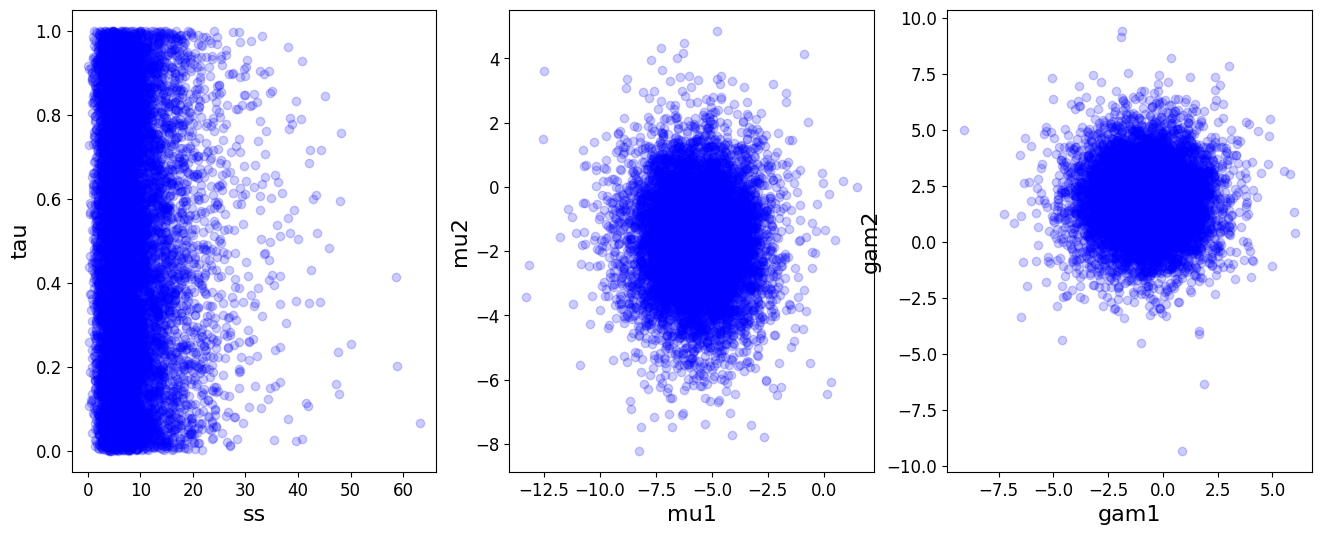

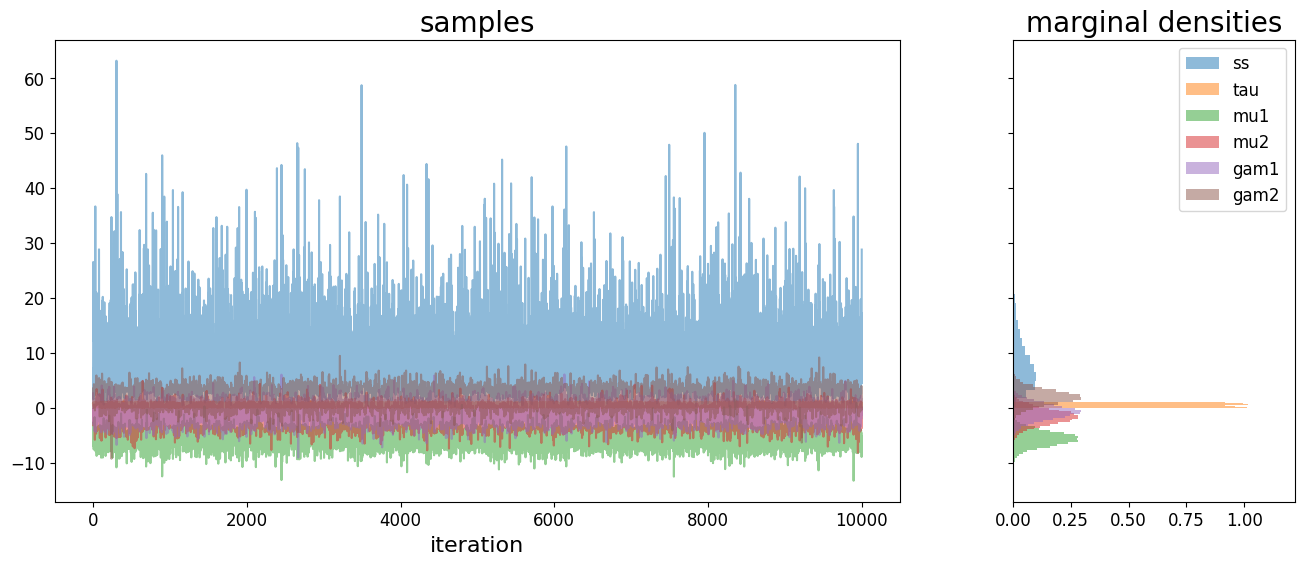

In [400]:
plot_dist(theta, plot_status=False)
plot_marginals(theta)